In [4]:
from graphviz import Digraph
import math

# Função para Criar Grafos

In [23]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s|data %.4f| grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# AutoGrad


A ideia das funções _backward() é definir como as variáveis que foram operadas para produzir uma nova variável devem afetar o gradiente durante o backpropagation.

* Adição (__add__): O gradiente de cada operando é simplesmente o gradiente da saída multiplicado por 1.
* Multiplicação (__mul__): O gradiente de cada operando é o gradiente da saída multiplicado pelo valor do outro operando.
* Tangente Hiperbólica (tanh): O gradiente do operando é o gradiente da saída multiplicado pela derivada da tangente hiperbólica.

In [172]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.topo = []
    
    def __repr__(self):
        if self.label != "":
            return f"Value(label={self.label}, data={self.data})"
        else:
            return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), "-")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int or float"
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += (out.grad)* other * self.data**(other-1)
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self*other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x  = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t * t) * out.grad
        out._backward = _backward
        
        return out
    

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()
        self.topo = topo

In [173]:
# Criação dos objetos
x1 = Value(2, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")
b = Value(6.881373, label="b")

# Operações
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

o.backward()


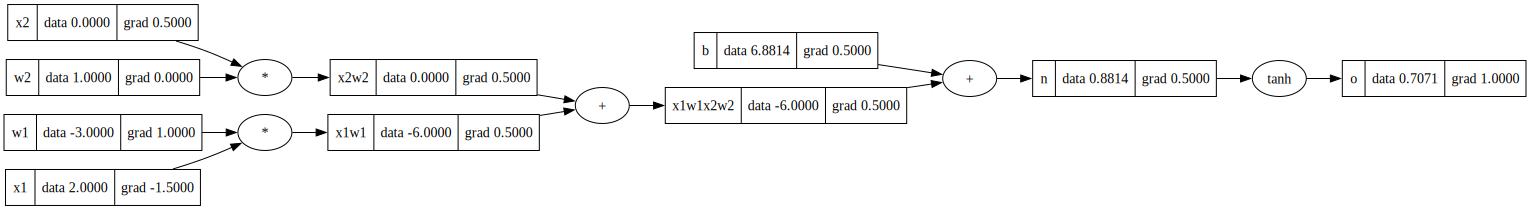

In [174]:
draw_dot(o)

In [175]:
# Criação dos objetos
x1 = Value(2, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")
b = Value(6.881373, label="b")

# Operações
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
e = (2*n).exp()
o = (e-1)/(e+1); o.label = "o"

o.backward()


# Neural Network

In [317]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(self.w[i]*x[i] for i in range(len(x))) + self.b
        out = act.tanh()
        return out
    
    def __repr__(self):
        return f"Neuron({len(self.w)})"
    

class Layer:
    def __init__(self, nin, nout):
        #nin = number of inputs to the layer
        #nout = number of neurons on the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        #return outs[0] if len(outs) == 1 else outs
        return outs
    
    def __repr__(self):
        return f"Layer({self.neurons})"

class MLP:
    def __init__(self, nin, nouts):
        #nin = number of inputs to the network
        #nouts = list with number of neurons in each layer
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i],sizes[i+1]) for i in range(len(nouts))]

    def __repr__(self):
        return f"MLP({[len(layer.neurons) for layer in self.layers]})"
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def fit(self, X, Y, epochs=100, lr=0.01):
        loss_history = []
        for epoch in range(epochs):
            loss = 0
            for x, y in zip(X,Y):
                pred = self(x)
                loss += sum((pred[i]-y[i])**2 for i in range(len(y)))
            loss_history.append(loss.data)
            loss.backward()
            for layer in self.layers:
                for neuron in layer.neurons:
                    neuron.w = [w - lr*w.grad for w in neuron.w]
                    neuron.b = neuron.b - lr*neuron.b.grad
        return loss_history
            

X = [[-3.53671936695919, -1.120069980485852], [-0.17143255463343246, -0.7712545005555792], [-0.9865370692714034, -0.7432690517173329], [-3.5052885337607527, -1.0155910709810791], [-1.1587737356861216, 0.6028152009564428], [-2.5582113047431614, -3.33656340916613], [-0.737683988747636, 0.30508524166066797], [3.3869256602087927, -2.7389336117945384], [3.6272868667966183, -0.8428553068649266], [-0.8952109426926808, 0.8049503647195344], [0.9101424896493918, -3.3917217541535027], [-4.152664552218326, -0.7623192256320782], [-4.044334057007255, -1.8427718188052322], [3.271480440317299, -1.6514838749716212], [3.3622628723761605, 1.608977372703021], [3.0475505243610006, 1.8577913884269266], [1.2044566773122947, 0.1538377262200074], [2.0417810286113864, -3.573368265148563], [0.6377657423566386, -3.567257507662604], [0.6358376029556627, -0.6769947138080791], [4.388181120620318, -0.5931023471301711], [0.3646231812993636, -1.1427162673101914], [-1.4104055689837152, 0.34818934711346256], [0.219644216

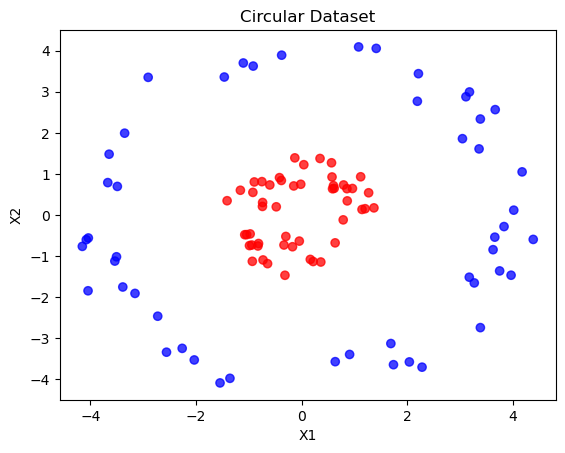

In [324]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Number of points
num_points = 100

# Generate random angles
angles = np.random.uniform(0, 2 * np.pi, num_points)

# Generate random radii with two different scales
radii = np.concatenate([np.random.uniform(0.5, 1.5, num_points // 2), np.random.uniform(3.5, 4.5, num_points // 2)])

# Shuffle the radii to mix low and high radius points
np.random.shuffle(radii)

# Convert polar coordinates to Cartesian coordinates
X = np.column_stack((radii * np.cos(angles), radii * np.sin(angles)))

# Generate labels: 1 for low radius, 0 for high radius
Y = np.array([[1] if r < 2 else [0] for r in radii])

# Print the dataset
print("X =", X.tolist())
print("Y =", Y.tolist())

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=Y.flatten(), cmap='bwr', alpha=0.75)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circular Dataset')
plt.show()


mlp = MLP(3,[4,4,1])
fitado = mlp.fit(X,Y,epochs=200, lr=0.01)

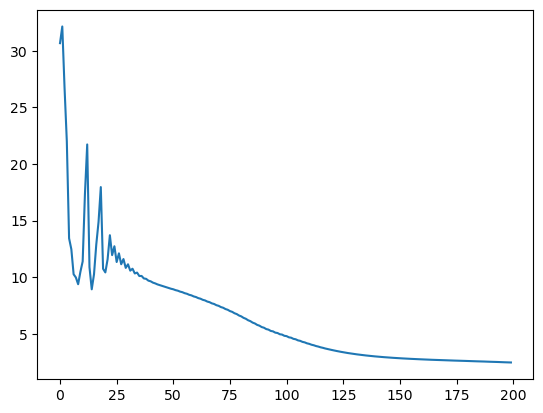

In [325]:
import matplotlib.pyplot as plt
plt.plot(fitado)